In [1]:
## Demarrage du projet ##
1+1 #Ca porte chance

2

In [2]:
from Data import DataLoader
from Data import RadarDataSet
from PreProcessing.domaines.passage_freq import get_signal_frequentiel
from Models.PolynomialRegressor import PolynomialRegressor
from Models.BasicNNModel import BasicNNModel
from Models.BasicAutoEncoder import BasicAutoEncoder
from PreProcessing.utils import data_to_complex

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Chargement des données

In [4]:
data_loader = DataLoader.DataLoader()
data, labels = data_loader.load_data()

In [5]:
## Chargement des données
data, labels = data_loader.load_data()

radar_dataset = RadarDataSet.RadarDataSet(data,labels,0.1) #0.2 is the test size ( 80% train data, 20% test data)
radar_dataset.add_frequential_data()
radar_dataset.y_test.shape

(310, 180)

## Test plot premier signal

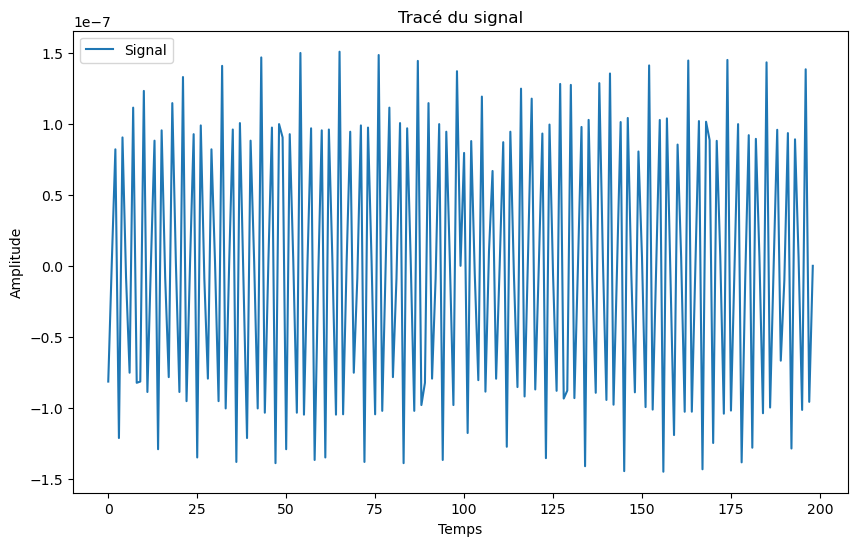

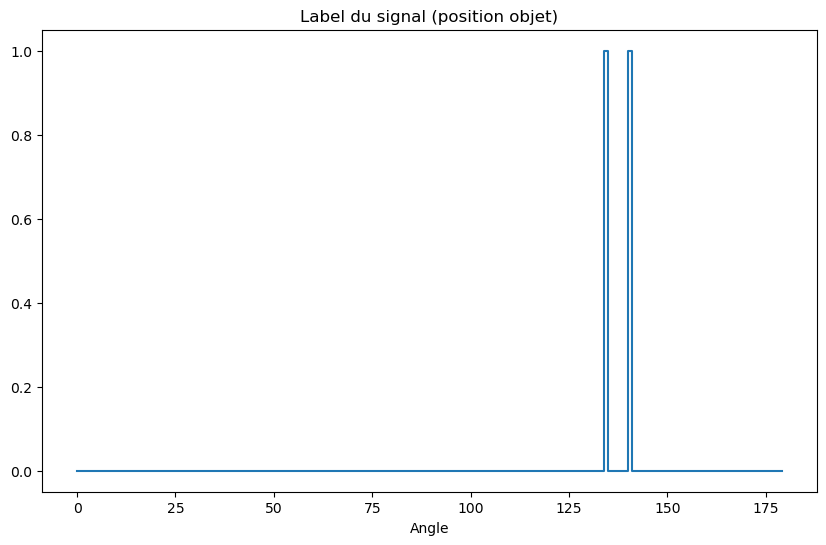

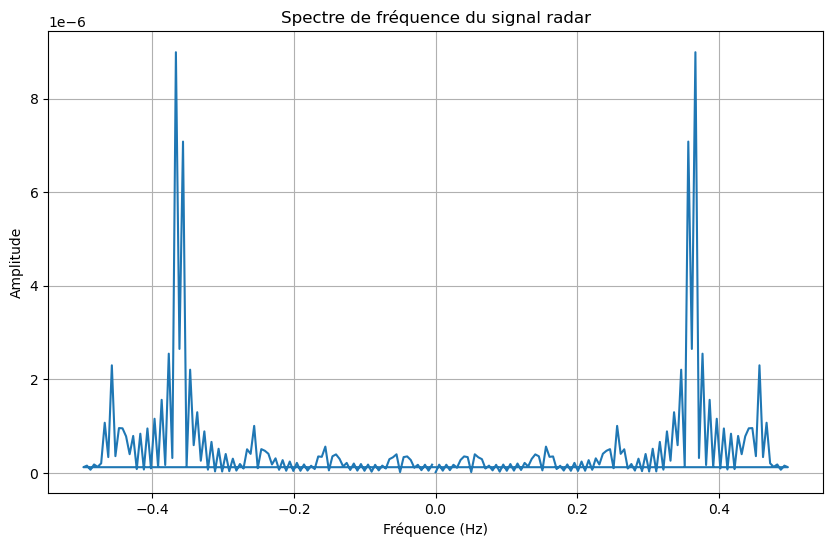

In [6]:
radar_dataset.plot(0) #Plot the first signal

# Chargement de différents modèles

In [7]:

basicNNModel1 = BasicNNModel()
basicNNModel1.load("basicNNModel1")

basicNNModel2 = BasicNNModel()
basicNNModel2.load("basicNNModel2")

basicCNNModel1 = BasicNNModel()
basicCNNModel1.load("basicCNNModel4_temp")

basicAutoEncoder = BasicAutoEncoder()
basicAutoEncoder.load("basicAutoEncoder")
X_test_encoded = basicAutoEncoder.encode(radar_dataset.X_test).squeeze()

10/10 [==============================] - 0s 1ms/step


# Prediction des données de test + évaluation

 4/10 [===========>..................] - ETA: 0s - loss: 0.0144 - accuracy: 0.5781

D:\anaconda\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


10/10 [==============================] - 0s 18ms/step - loss: 0.0097 - accuracy: 0.5194
Loss evaluation: [0.009740105830132961, 0.5193548202514648]
10/10 [==============================] - 0s 11ms/step
Mean square error: 0.002376087554534921
Root Mean square error: 0.048745128521062706


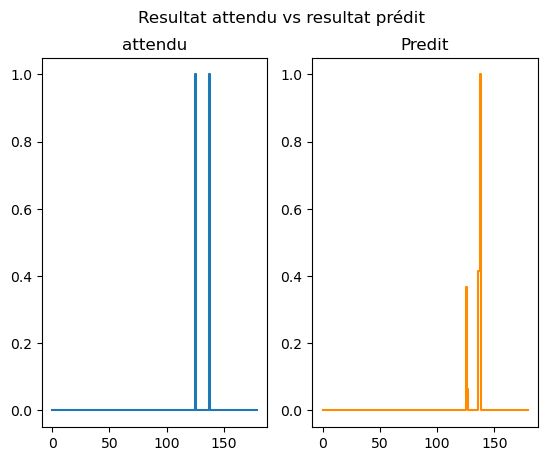

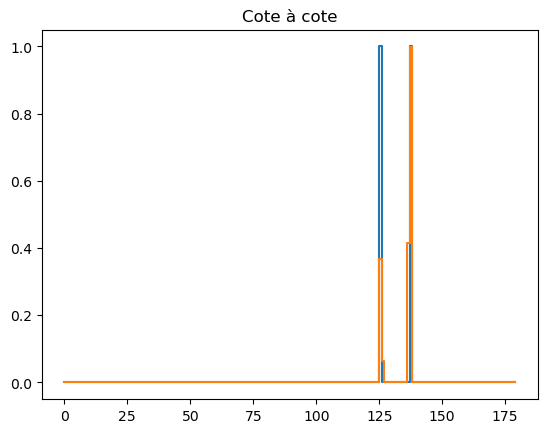

In [8]:
y_pred_CNN1 = basicCNNModel1.predict(radar_dataset.X_test)

basicCNNModel1.evaluate(radar_dataset.X_test,radar_dataset.y_test)

Mean square error: 0.018981206879856397
Root Mean square error: 0.1377723008440245


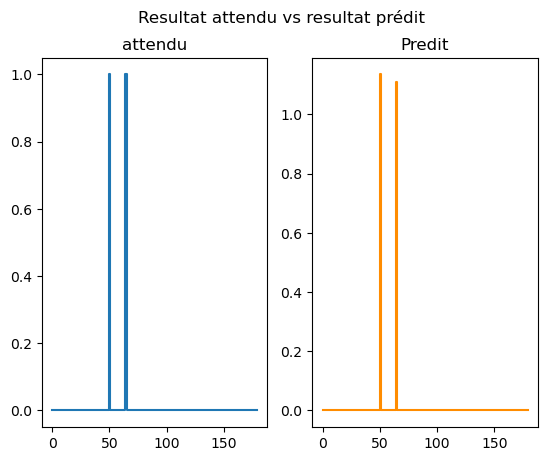

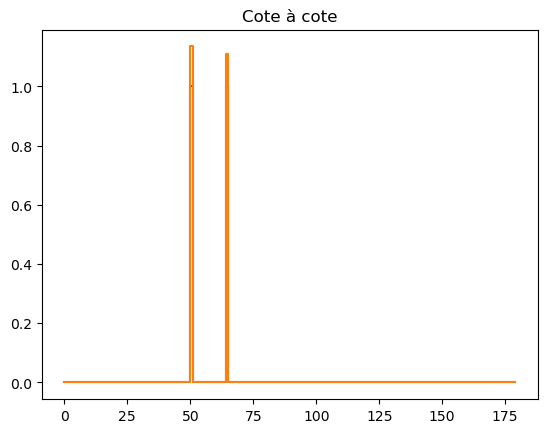

In [9]:
#POLYNOMIAL REGRESSION

polynomialRegressor = PolynomialRegressor()
polynomialRegressor.train(abs(radar_dataset.X_freq_train),radar_dataset.y_train)
polynomialRegressor.evaluate(abs(radar_dataset.X_freq_test),radar_dataset.y_test)
